# TP 3: Équation de la chaleur en 2D

On s'intéresse à la résolution numérique de l'équation de la chaleur sur $[0,T]\times \Omega$ où $\Omega = ]0,1[^d$ et $d\in\{1,2\}$. On considèrera l'équation avec conditions de Neumann homogènes:

$$
(1D) \quad \left\{\begin{aligned}
&\frac{\partial u}{\partial t}(x,t) = \frac{\partial^2 u}{\partial x^2}(x,t)  \hbox{ sur } ]0,1[\\
&\frac{\partial u}{\partial x}(t,0) = \frac{\partial u}{\partial x}(t,1) = 0 \hbox{ pour } t\in [0,T]\\
&u(0,\cdot) = u_0
\end{aligned}\right. 
$$

$$
(2D) \quad \left\{\begin{aligned}
&\frac{\partial u}{\partial t}(x,t) = \frac{\partial^2 u}{\partial x^2}(x,t) + \frac{\partial^2 u}{\partial y^2}(x,y,t)   \hbox{ sur } \Omega\\
&\frac{\partial u}{\partial x}(t,0,y) = \frac{\partial u}{\partial x}(t,1,y) = 0 \hbox{ pour } t\in [0,T], x\in\{0,1\}, y \in[0,1] \\
&\frac{\partial u}{\partial y}(t,x,0) = \frac{\partial u}{\partial y}(t,x,1) = 0 \hbox{ pour } t\in [0,T], y\in\{0,1\},x \in[0,1] \\
&u(0,\cdot) = u_0
\end{aligned}\right. 
$$


In [2]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import scipy.sparse.linalg as sparse
def solve_iterative(Operator, b):
    M = len(b)
    A = sparse.LinearOperator([M,M], matvec=Operator)
    x,info = sparse.cg(A,b)
    return x

def solve_iterative_2d(Operator, b):
    assert(b.shape[0] == b.shape[1])
    M = b.shape[0]
    A = sparse.LinearOperator([M*M,M*M], matvec=lambda u: np.reshape(Operator(np.reshape(u,(M,M))), M*M));
    x,info = sparse.cg(A,np.reshape(b,M*M))
    return np.reshape(x,(M,M))

## 1.  Cas 1D avec résolution itérative du système linéaire

On rappelle que le schéma implicite pour (1D) est de la forme
$$
\left\{\begin{aligned}
& \frac{1}{\tau} (u_{j}^{n+1} - u_j^n) = \frac{1}{h^2} (u_{j-1}^{n+1} - 2 u_j^{n+1} + u_{j+1}^{n+1}) &\hbox{ pour } 1\leq j \leq M, 0\leq n \leq N-1\\
& u_0^n = u_1^n \hbox{ et } u_{M+1}^n = u_M^n &\hbox{ pour } 0\leq n\leq N \\
& u_j^0 = u_0(x_j) &\hbox{ pour } 1\leq j\leq M+1
\end{aligned}\right.,
$$
En posant $v^n := (u_1^n,\dots,u^n_M)$, le schéma peut être réécrit de la manière suivante:
$$ v^{n+1} = \left(\mathrm{Id}_M - \frac{\tau}{h}(D_h^+ - D_h^-)\right)^{-1} v^n$$
où les opérateurs/matrices "dérivées directionnelles" $D_h^+$ et $D_h^-$ sont définis de la manière suivante:
$$ D_h^+ v = \frac{1}{h}(v_1 - v_0, \dots, v_{M} - v_{M-1}, 0) \in \mathbb{R}^M $$
$$ D_h^- v = \frac{1}{h}(0, v_1 - v_0, \dots, v_{M} - v_{M-1}) \in \mathbb{R}^M, $$
on note que les zéros correspondent aux conditions de Neumann.


**Q1)** Soit $u = $ np.random.random$(10)$. Tester l'accès aux éléments $(u_n,\dots,u_{m-1})$ de $u$ via la syntaxe $u[n:m]$. En déduire deux fonctions DP$(u,h)$ DM$(u,h)$ calculant respectivement $D_h^+ u$ et $D_h^- u$.

In [47]:
def DP(u,h):
    M = len(u)
    v = np.zeros(len(u))
    v[0:M-1] = (u[1:M] - u[0:(M-1)])/h
    return v

def DM(u,h):
    M = len(u)
    v = np.zeros(len(u))
    v[1:M] = (u[1:M] - u[0:(M-1)])/h
    return v

En utilisant DM et DP, on peut définir une fonction python $A$ calculant $u\mapsto (\mathrm{Id}_M - (\tau/h)(D_h^+ - D_h^-)) u$. L'intérêt de pouvoir résoudre le système $A(u^{n+1}) = u^n$ par une méthode itérative qui ne nécessite pas de connaître $A$ mais seulement de savoir calculer $A(u)$ (ici, on utilise la méthode du gradient conjugué). En particulier, il n'y a aucun besoin de stocker la matrice en mémoire !

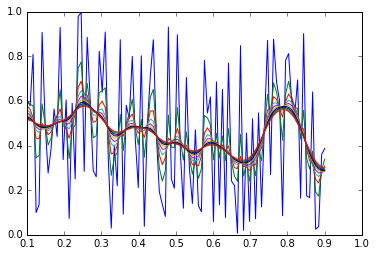

In [48]:
N = 10
M = 100
T = 0.1
h = 1.0/10
tau = T/N

x = np.linspace(h,1.0-h,M)
u = np.random.random(M)

# On définit une fonction via la syntaxe "lambda",
# ici, A(u) retourne u - (tau/h)*(DP(u,h) - DM(u,h))
A = lambda u: u - (tau/h)*(DP(u,h) - DM(u,h))
for i in xrange(N):
    plt.plot(x,u)
    u = solve_iterative(A, u)    

## 2.  Cas 2D avec résolution itérative du système linéaire

Pour discrétiser le problème en 2D on considère une discrétisation $(x_i)_{1\leq i\leq M+1}, (y_j)_{1\leq j\leq M+1}$ de l'axe des abcisse et des ordonnées, avec $x_i = hi$, $y_j = hj$ et $h=1/(M+1)$. La discrétisation de l'espace est donnée par la grille de points $p_{i,j} = (x_i,y_j) \in [0,1]^2, $
et on note $u_{i,j}^n$ l'approximation de la solution $u$ en $(x_i,y_j,t_n)$. On peut écrire un schéma implicite pour (2D) de la manière suivante:
$$
\left\{\begin{aligned}
& \frac{1}{\tau} (u_{i,j}^{n+1} - u_{i,j}^n) = \frac{1}{h^2} (u_{i,j-1}^{n+1} + u_{i,j+1}^{n+1} + u_{i-1,j}^{n+1} + u_{i+1,j}^{n+1} +   - 4 u_{i,j}^{n+1})&\hbox{ pour } 1\leq i,j \leq M, 0\leq n \leq N-1\\
& \frac{u_{0,j}^n - u_{1,j}^n}{h} = \frac{u_{M+1,j}^n - u_{M,j}^n}{h} = 0 &\hbox{ pour } 0\leq n\leq N \hbox{ et } 1\leq j\leq M+1 \\
& \frac{u_{i,0}^n - u_{i,1}^n}{h} = \frac{u_{i,M+1}^n - u_{i,M}^n}{h} = 0 &\hbox{ pour } 0\leq n\leq N \hbox{ et } 1\leq i\leq M+1 \\
& u_{i,j}^0 = u_0(p_{ij}) &\hbox{ pour } 1\leq j\leq M+1
\end{aligned}\right.,
$$
On remarque qu'il manque des équations pour les valeurs de $u$ aux quatres "coins", i.e. $u_{0,0}^n, u_{M+1,0}^n, u_{0,M+1}^n, u_{M+1,M+1}$, *qui ne font donc par partie des inconnnues*.

On peut vérifier qu'en considérant $v^n := (u^n_{i,j})_{1\leq i,j \leq M} \in \mathcal{M}_{M,M}$  comme une matrice de taille $M\times M$, le schéma peut être réécrit de la manière suivante:
$$ A(v^{n+1}) = v^n$$
$$ A(v) = u - \frac{\tau}{h}(D_{x,h}^+ v  - D_{x,h}^- v + D_{y,h}^+ v - D_{y,h}^+ v)$$
où les opérateurs $D_{x,h}^\pm,D_{y,h}^\pm: \in \mathcal{M}_{M,M}\to  \mathcal{M}_{M,M}$ correspondent aux dérivées partielles à droite et à gauche. Par exemple, la $j$ième ligne de $D_{x,h}^+ v$ est donnée par:
$$ (D_{x,h}^+ v)_{\cdot, j} = \frac{1}{h}(v_{1,j} - v_{0,j}, \dots, v_{M,j} - v_{M-1,j}, 0) $$
Là encore, le zéro final provient de la conditions de Neumann.

**Q2)** Écrire des fonctions DxP, DxM, DyP et DyM prenant en entrée une matrice $u$ de taille $M\times M$ et retournant  les matrices des dérivées partielles directionnelles $D_{x,h}^+(u)$, $D_{x,h}^-(u), D_{y,h}^+(u)$, et  $D_{y,h}^-(u)$. Pour faire concis, on n'hésitera pas à utliser $u[m:n, r:s]$ pour extraire la sous-matrice $(u_{i,j})_{m\leq i\leq n-1, r\leq j\leq s-1}$. (Expérimenter sur de petits exemples!) 



In [4]:
def DxP(u,h):
    M = u.shape[0]
    v = np.zeros((M,M))
    v[:,0:(M-1)] = (u[:,1:M] - u[:,0:(M-1)])/h
    return v
def DxM(u,h):
    M = u.shape[0]
    v = np.zeros((M,M))
    v[:,1:M] = (u[:,1:M] - u[:,0:(M-1)])/h
    return v
def DyP(u,h):
    M = u.shape[0]
    v = np.zeros((M,M))
    v[0:(M-1),:] = (u[1:M,:] - u[0:(M-1),:])/h
    return v
def DyM(u,h):
    M = u.shape[0]
    v = np.zeros((M,M))
    v[1:M,:] = (u[1:M,:] - u[0:(M-1),:])/h
    return v

**Q3)** Écrire une fonction calculant $A(u)$ où l'opérateur $A$ est défini ci-dessus. On supposera toujours que $u$ est représenté par une matrice. Résoudre l'équation de la chaleur en 2D pour les paramètres ci-dessous (on utilisera v = solve_iterative_2d(A,u) pour résoudre le système linéaire $A(u) = v$).

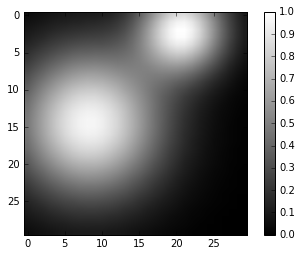

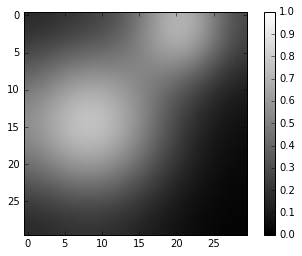

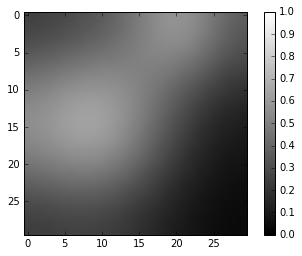

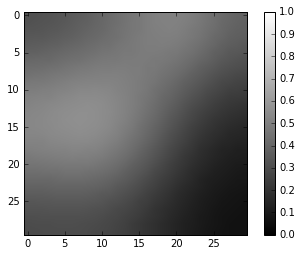

In [7]:
def u0(X,Y):
    h = 1.0/M
    u = np.exp(-10.0*(np.power(X - 0.3,2.0) + np.power(Y - 0.5,2.0)))
    u = u + np.exp(-30.0*(np.power(X - 0.7,2.0) + np.power(Y - 0.1,2.0)))
    u = u/np.max(u)
    #u = u + 0.3*np.random.random((M,M)) # -> si on veut rajouter du bruit
    return u

M = 30
h = 1.0/M
T = 0.05
N = 5
tau = T/N

x = np.linspace(h,1.0-h,M)
y = np.linspace(h,1.0-h,M)
X, Y = np.meshgrid(x,y) # X et Y sont des matrices encodant les fonctions coordonnées (x,y) -> x  et (x,y) -> y

u = u0(X,Y)
# On peut visualiser u via la fonction plt.imshow(u, vmin=0.0, vmax=1.0, cmap='gray'). Ne pas hésiter à faire de même pour
# les fonctions coordonnées.

A = lambda u: u - (tau/h)*(DxP(u,h) - DxM(u,h) + DyP(u,h) - DyM(u,h))
for i in xrange(4):
    plt.imshow(u, vmin=0.0, vmax=1.0, cmap='gray')
    plt.colorbar()
    plt.show()
    u = solve_iterative_2d(A, u)



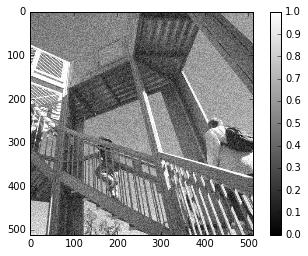

2.71220213589e-05


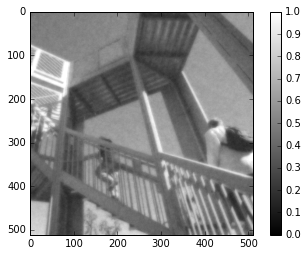

3.74973754674e-05


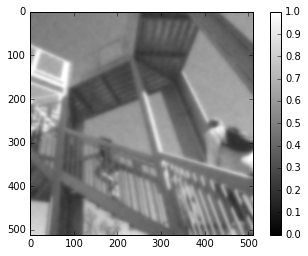

3.27021146094e-05


In [11]:
import scipy as sp
u = sp.misc.ascent().astype(float)
u = u / np.max(u)
M = 512
u = u + 0.3*np.random.random((M,M)) 
h = 1.0/M
tau = 0.00002
A = lambda u: u - (tau/h)*(DxP(u,h) - DxM(u,h) + DyP(u,h) - DyM(u,h))
for i in xrange(3):
    plt.imshow(u, cmap='gray', vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.show()
    un = solve_iterative_2d(A, u)
    print(np.max(np.abs(A(un) - u)))
    u = un

## 3. Analyse du schéma 2D

**Q2)** Montrer que les solutions du schéma (en supposant qu'eelles existent) vérifient le principe du maximum discret,
$$ \forall n< N,  \min_{1\leq i,j \leq M} u_{i,j}^n \leq \min_{1\leq i,j \leq M} u_ij^{n+1} $$
$$ \forall n< N,  \max_{1\leq i,j \leq M} u_{i,j}^{n+1} \leq \max_{1\leq i,j \leq M} u_{i,j}^{n}. $$
En déduire la stabilité du schéma en norme infinie:
$$ \max_{0\leq n\leq N}\max_{0\leq i,j\leq M+1} |u_{i,j}^n| \leq \|u_0\|_\infty $$

**Q3)** Étudier la consistance du schéma.
[comment]: %$$ \frac{1}{\tau}(u(x_i,x_j,t_{n+1}) - (u(x_i,x_j,t_n)) - \frac{1}{h^2} (u(x_i,y_{j-1},t_{n+1}) + 
[comment]: %u(x_i,y_{j+1},t_{n+1})+u(x_{i+1},y_{j},t_{n+1})+u(x_{i-1},y_{j},t_{n+1}) - 4u(x_{i},y_{j},t_{n+1}))$$

